# Energy Rating Task

Objective: predict CURRENT_ENERGY_RATING given the address.

How is the energy rating calculated? The EPC for a building is calculated using variants of the Standard Assessment Procedure (SAP). The SAP considers the property’s build quality, its size and shape, the way it is used, the heating and hot water system, the type of glazing and insulation installed, and other factors. The rating of new build properties is calculated with an As Built SAP. For existing properties, domestic energy assessors conduct site surveys and calculate the score using the Reduced Data Standard Assessment Procedure method (RdSAP). The RdSAP is not as accurate as the SAP, as many assumptions are made within the software. These are based on defaults using the building regulation requirements for each element based on the approximate age of the property. Most implementations of the SAP and RdSAP calculations for EPCs are currently commercial, although some [open source efforts](https://rcuk-cee.github.io/epctk/) exist.

### Requirements

Use conda: `conda env create -f environment.yml`

### Imports

In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shap
import xgboost as xgb
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import cross_validate, train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_recall_fscore_support

### Configuration

In [2]:
data_dir = Path("../")
data_filename = "certificates.csv"
data_path = data_dir / data_filename
data_schema_filename = "columns.csv"
data_schema_path = data_dir / data_schema_filename

feature_to_predict = "CURRENT_ENERGY_RATING"
train_set_ratio = 0.9
max_num_classes_in_feature = 100
num_cv_folds = 5
seed = 42

### Load the data

In [3]:
data_schema = pd.read_csv(data_schema_path, index_col='column')

data_schema = data_schema[data_schema['filename'] == data_filename]['datatype']
cols_with_dates = [key for key, dtype in data_schema.items() if "date" in dtype]
type_mappings = {
    'integer': "Int64",
    'date': "string",
    'datetime': "string",
    'decimal': "Float64",
    'float': "Float64"
}
data_schema = data_schema.replace(type_mappings).to_dict()

In [4]:
na_values = [  # determined by listing unique values in each column
    "NODATA!",
    "NO DATA!",
    "INVALID!",
    "Unknown",
    "unknown",
    "not defined",
    "%%MAINHEATCONTROL%%"
]
data = pd.read_csv(
    data_path,
    index_col='LMK_KEY',  # unique for each row
    dtype=data_schema,
    parse_dates=cols_with_dates,
    na_values=na_values
)
display(data)

,ADDRESS1,ADDRESS2,ADDRESS3,POSTCODE,BUILDING_REFERENCE_NUMBER,CURRENT_ENERGY_RATING,POTENTIAL_ENERGY_RATING,CURRENT_ENERGY_EFFICIENCY,POTENTIAL_ENERGY_EFFICIENCY,PROPERTY_TYPE,...,LOCAL_AUTHORITY_LABEL,CONSTITUENCY_LABEL,POSTTOWN,CONSTRUCTION_AGE_BAND,LODGEMENT_DATETIME,TENURE,FIXED_LIGHTING_OUTLETS_COUNT,LOW_ENERGY_FIXED_LIGHT_COUNT,UPRN,UPRN_SOURCE
LMK_KEY,,,,,,,,,,,,,,,,,,,,,
20e080e980b1adf8135ed034e06aa6538031386ca324da6c273f9104e745e597,25 Priory Field Drive,<NA>,<NA>,HA8 9PT,10003615320,C,B,75,82,House,...,Barnet,Hendon,EDGWARE,England and Wales: 1996-2002,2022-11-24 12:49:30,Owner-occupied,20.0,<NA>,200095017,Energy Assessor
760043321412014101221121693949196,"70, Harcourt Avenue",<NA>,<NA>,HA8 8YN,1692136968,D,B,61,85,House,...,Barnet,Hendon,EDGWARE,England and Wales: 1950-1966,2014-10-12 21:12:16,rental (social),8.0,8.0,200057135,Address Matched
1342791749962015071408401177498105,"68, Swan Drive",<NA>,<NA>,NW9 5DE,0700457378,C,B,73,85,House,...,Barnet,Hendon,LONDON,England and Wales: 1983-1990,2015-07-14 08:40:11,owner-occupied,<NA>,<NA>,200111781,Address Matched
736985809262016070111401454988456,"16, Rose Way",<NA>,<NA>,HA8 9SD,5546044968,D,C,60,75,Flat,...,Barnet,Hendon,EDGWARE,England and Wales: 1967-1975,2016-07-01 11:40:14,rental (social),<NA>,<NA>,200099210,Address Matched
50804143212009012217495402910959,Ground Floor Flat,8 The Drive,<NA>,NW11 9SR,9993326568,D,D,55,65,Flat,...,Barnet,Finchley and Golders Green,LONDON,England and Wales: 1900-1929,2009-01-22 17:49:54,rental (private),<NA>,<NA>,200145509,Address Matched
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
00f74daf31d251db1f91527e493d8ab5f4822b8414811eff1020568312ba39cb,57 Balfour Grove,London,<NA>,N20 0SN,10005287474,C,C,69,72,Flat,...,Barnet,Chipping Barnet,<NA>,England and Wales: 1950-1966,2023-11-30 16:39:55,Rented (social),4.0,<NA>,200006058,Energy Assessor
026c5940a9a767259eb6e5a7a8bee30bdbdc64ce384c037d07a9c6978bf96517,3 Arundel Gardens,Edgware,<NA>,HA8 0RN,10003252067,D,B,63,84,House,...,Barnet,Hendon,<NA>,England and Wales: 1950-1966,2023-11-30 16:34:29,Rented (social),12.0,<NA>,200004365,Energy Assessor
04a152eb9985ff1538b147bec13e423b410c76351945290fdab18c337983a3b1,Flat 1,25 Wetherill Road,Muswell Hill,N10 2LT,10005314376,C,C,69,77,Flat,...,Barnet,Chipping Barnet,LONDON,England and Wales: 1900-1929,2023-11-20 07:58:10,Rented (private),10.0,<NA>,200211514,Energy Assessor


### Basic data validation

In [5]:
assert data.index.is_unique
assert not data['CURRENT_ENERGY_RATING'].isna().any()

### Manually remove features

- Complexity:
    - Free text fields (ending with "_DESCRIPTION"), which are both in English and Welsh, could be later preprocessed with some basic regexp or text embeddings, but are too complex at this point.
    - Text fields that are not quite free but have too many classes (e.g. "POSTCODE"). Since text fields will be set as categorical, we will keep the max number of classes under `max_num_classes_in_feature`.
- Data leakage: Any feature that is highly correlated with the output but wouldn't be accessible in practice. Includes "CURRENT_ENERGY_EFFICIENCY" and potential ratings (starting or ending with "POTENTIAL"). For some features (e.g. "ENVIRONMENT_IMPACT_CURRENT"), their accessibility would need to be discussed.
- Uninformative features:
    - "UPRN" is unique per property and remains the same if there are several lodgments over time for the same property.
    - "UPRN_SOURCE" is probably irrelevant.
    - "LODGEMENT_DATETIME" does not add any relevant information to LODGEMENT_DATE (and it also has unconsistent formatting).
    - "INSPECTION_DATE" is very close to "LODGEMENT_DATE".
    - Some features have a single value (besides NA).

In [6]:
free_text_features = [col for col in data.columns if "_DESCRIPTION" in col]
too_many_classes_features = [col for col in data.columns if data[col].dtype == 'string' and len(data[col].unique()) > max_num_classes_in_feature]
leak_features = [col for col in data.columns if "POTENTIAL" in col] + ["CURRENT_ENERGY_EFFICIENCY"]
uninformative_features = ['UPRN', 'UPRN_SOURCE', 'LODGEMENT_DATETIME', 'INSPECTION_DATE']
single_value_features = [col for col in data.columns if len(data[col].dropna().unique()) < 2]

removed_features = (
    free_text_features
    + too_many_classes_features
    + leak_features
    + uninformative_features
    + single_value_features
)
print(removed_features)
data = data.drop(removed_features, axis='columns')

['HOTWATER_DESCRIPTION', 'FLOOR_DESCRIPTION', 'WINDOWS_DESCRIPTION', 'WALLS_DESCRIPTION', 'SECONDHEAT_DESCRIPTION', 'ROOF_DESCRIPTION', 'MAINHEAT_DESCRIPTION', 'MAINHEATCONT_DESCRIPTION', 'LIGHTING_DESCRIPTION', 'ADDRESS1', 'ADDRESS2', 'ADDRESS3', 'POSTCODE', 'BUILDING_REFERENCE_NUMBER', 'FLOOR_DESCRIPTION', 'WALLS_DESCRIPTION', 'ROOF_DESCRIPTION', 'MAINHEAT_DESCRIPTION', 'LIGHTING_DESCRIPTION', 'ADDRESS', 'POTENTIAL_ENERGY_RATING', 'POTENTIAL_ENERGY_EFFICIENCY', 'ENVIRONMENT_IMPACT_POTENTIAL', 'ENERGY_CONSUMPTION_POTENTIAL', 'CO2_EMISSIONS_POTENTIAL', 'LIGHTING_COST_POTENTIAL', 'HEATING_COST_POTENTIAL', 'HOT_WATER_COST_POTENTIAL', 'CURRENT_ENERGY_EFFICIENCY', 'UPRN', 'UPRN_SOURCE', 'LODGEMENT_DATETIME', 'INSPECTION_DATE', 'LOCAL_AUTHORITY', 'COUNTY', 'SHEATING_ENERGY_EFF', 'SHEATING_ENV_EFF', 'LOCAL_AUTHORITY_LABEL']


### Transform the remaining features
- Set remaining string features as categorical
- Convert datetime to year as day/month is probably irrelevant
- Create a copy with encoded categories

In [7]:
for col in data.select_dtypes('string').columns:
    data[col] = data[col].astype('category')

data['LODGEMENT_DATE'] = data['LODGEMENT_DATE'].dt.year

cat_columns = data.select_dtypes(['category']).columns
data_encoded = data.copy()
data_encoded[cat_columns] = data_encoded[cat_columns].apply(lambda x: x.cat.codes)
data_encoded

,CURRENT_ENERGY_RATING,PROPERTY_TYPE,BUILT_FORM,CONSTITUENCY,LODGEMENT_DATE,TRANSACTION_TYPE,ENVIRONMENT_IMPACT_CURRENT,ENERGY_CONSUMPTION_CURRENT,CO2_EMISSIONS_CURRENT,CO2_EMISS_CURR_PER_FLOOR_AREA,...,FLOOR_HEIGHT,PHOTO_SUPPLY,SOLAR_WATER_HEATING_FLAG,MECHANICAL_VENTILATION,CONSTITUENCY_LABEL,POSTTOWN,CONSTRUCTION_AGE_BAND,TENURE,FIXED_LIGHTING_OUTLETS_COUNT,LOW_ENERGY_FIXED_LIGHT_COUNT
LMK_KEY,,,,,,,,,,,,,,,,,,,,,
20e080e980b1adf8135ed034e06aa6538031386ca324da6c273f9104e745e597,2,2,0,2,2022,7,70,148.0,4.7,26.0,...,2.41,0.0,0,2,2,30,20,1,20.0,<NA>
760043321412014101221121693949196,3,2,5,2,2014,10,57,240.0,3.9,46.0,...,<NA>,0.0,-1,2,2,30,15,6,8.0,8.0
1342791749962015071408401177498105,2,2,4,2,2015,7,71,170.0,2.6,30.0,...,<NA>,<NA>,0,2,2,63,18,4,<NA>,<NA>
736985809262016070111401454988456,3,1,5,2,2016,0,55,298.0,3.6,52.0,...,2.44,<NA>,0,2,2,30,16,6,<NA>,<NA>
50804143212009012217495402910959,3,1,0,1,2009,14,49,382.0,4.5,63.0,...,2.8,0.0,0,2,1,63,13,5,<NA>,<NA>
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
00f74daf31d251db1f91527e493d8ab5f4822b8414811eff1020568312ba39cb,2,1,0,0,2023,13,71,292.0,1.5,51.0,...,2.3,0.0,0,2,0,-1,15,3,4.0,<NA>
026c5940a9a767259eb6e5a7a8bee30bdbdc64ce384c037d07a9c6978bf96517,3,2,5,2,2023,13,58,270.0,3.3,48.0,...,2.45,0.0,0,2,2,-1,15,3,12.0,<NA>
04a152eb9985ff1538b147bec13e423b410c76351945290fdab18c337983a3b1,2,1,4,0,2023,13,68,227.0,2.2,40.0,...,2.6,0.0,0,2,0,63,13,2,10.0,<NA>


### Check the output distribution

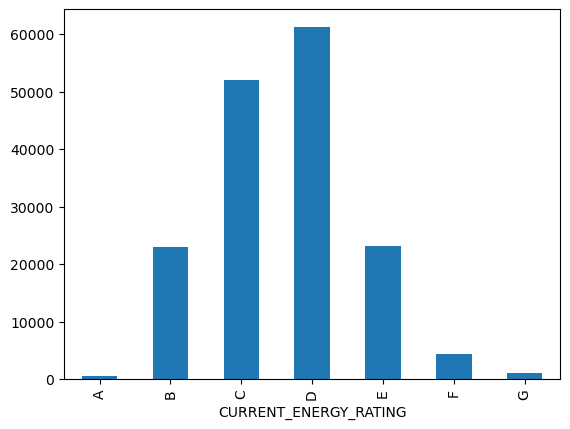

In [8]:
data[feature_to_predict].value_counts().sort_index().plot(kind='bar');

We can see that the data is very imbalanced. This is in line with what is generally known about the energy performance of buildings in the UK. The dip between 'E' and 'F' is probably due to the Minimum Energy Efficiency Standards for landlords (minimum of 'E' for rented properties). The dip between 'D' and 'E' might be specific to the area where EPCs were collected.

### Split the data into training/validation and test sets

Use stratified sampling to preserve the class distribution. Visually check that the distribution is the same.

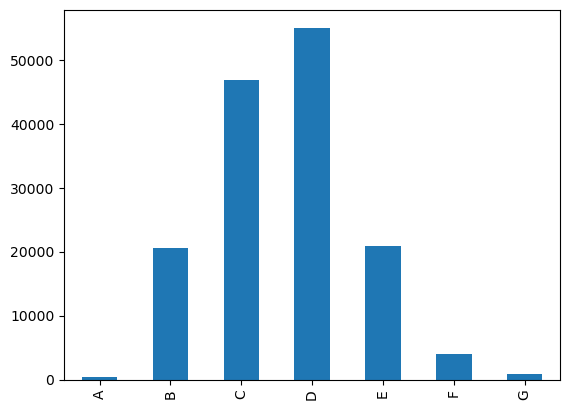

In [9]:
train_set, test_set = train_test_split(data_encoded, train_size=train_set_ratio, stratify=data_encoded[feature_to_predict])

X_train = train_set.drop(columns=feature_to_predict)
y_train = train_set[feature_to_predict]
X_test = test_set.drop(columns=feature_to_predict)
y_test = test_set[feature_to_predict]

train_set[feature_to_predict].value_counts().sort_index().set_axis(data[feature_to_predict].cat.categories).plot(kind='bar');

### Define the baselines

- "Mode" classifier: always returns the most frequent class in the training set
- "Stratified" classifier: returns random predictions with a distribution similar to that of the training set

In [10]:
mode_clf = DummyClassifier(strategy="most_frequent", random_state=seed)
stra_clf = DummyClassifier(strategy="stratified", random_state=seed)

### Define the classifier

The algorithm that we use (XGBoost, LightGBM variant) saves some feature preprocessing:
- It automatically handles missing values
- Decision trees (which we use here) are insensitive to the scale of the features and to correlated features

In [11]:
xgb_clf = xgb.XGBClassifier(
    tree_method="hist",
    # early_stopping_rounds=2,
    enable_categorical=True,
    device="cpu"
)

### Evaluate against baselines

We use cross-validation with `num_cv_folds` folds.

We compute precision, recall, and F1 score. This is better than accuracy because of class imbalance.
Each metric is computed per class and averaged.

This routine will use stratified folds.

In [12]:
scoring = ["precision_macro", "recall_macro", "f1_macro"]
classifiers = {
    'Mode': mode_clf,
    'Stratified': stra_clf,
    'LightGBM': xgb_clf
}
scores = {}
for name, clf in classifiers.items():
    scores[name] = cross_validate(
        clf,
        X_train,
        y_train,
        scoring=scoring,
        cv=num_cv_folds
    )

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


In [13]:
scores_avg = {clf: {score: values.mean() for score, values in clf_scores.items()} for clf, clf_scores in scores.items()}
pd.DataFrame(scores_avg).transpose()

,fit_time,score_time,test_precision_macro,test_recall_macro,test_f1_macro
Mode,0.097899,0.034623,0.052944,0.142857,0.077257
Stratified,0.106024,0.047538,0.141560,0.141563,0.141559
LightGBM,7.228647,0.140259,0.951924,0.935638,0.943540


### Evaluate class-wise performance of best classifier

In [14]:
def get_metrics(y_true, y_pred):
    precision, recall, fscore, _ = precision_recall_fscore_support(y_true, y_pred, zero_division=0)
    return pd.DataFrame({'Precision': precision, 'Recall': recall, 'F1': fscore}, index=data[feature_to_predict].cat.categories)

In [15]:
xgb_clf.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device='cpu', early_stopping_rounds=None,
              enable_categorical=True, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [16]:
xgb_y_pred = xgb_clf.predict(X_test)
xgb_metrics = get_metrics(y_test, xgb_y_pred)
display(xgb_metrics)

,Precision,Recall,F1
A,0.977273,0.955556,0.966292
B,0.977411,0.980820,0.979112
C,0.970515,0.973123,0.971817
D,0.966113,0.967847,0.966979
E,0.942474,0.938819,0.940643
F,0.920000,0.890661,0.905093
G,0.965517,0.875000,0.918033


As expected the classifier performs better on more represented classes. If it is important to predict 'A', 'F', and 'G' accurately we could weight or oversample these classes. In practice it might be more important to be accurate around legal cutoffs (e.g. above or below 'E', or even above or below 'C' in the future). To be discussed.

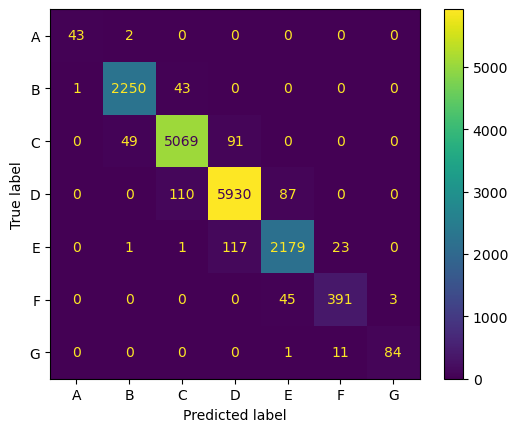

In [17]:
xgb_conf_disp = ConfusionMatrixDisplay.from_predictions(y_test, xgb_y_pred, display_labels=data[feature_to_predict].cat.categories)

It might be worth investigating the most significant errors, such as the 'D' predicted as 'A', to see if there is something special about this row, or some key information in the features that were removed.

### Analyse feature importance

First with Mean Decrease in Impurity (times a feature is used to split a node x proportion of samples it splits).

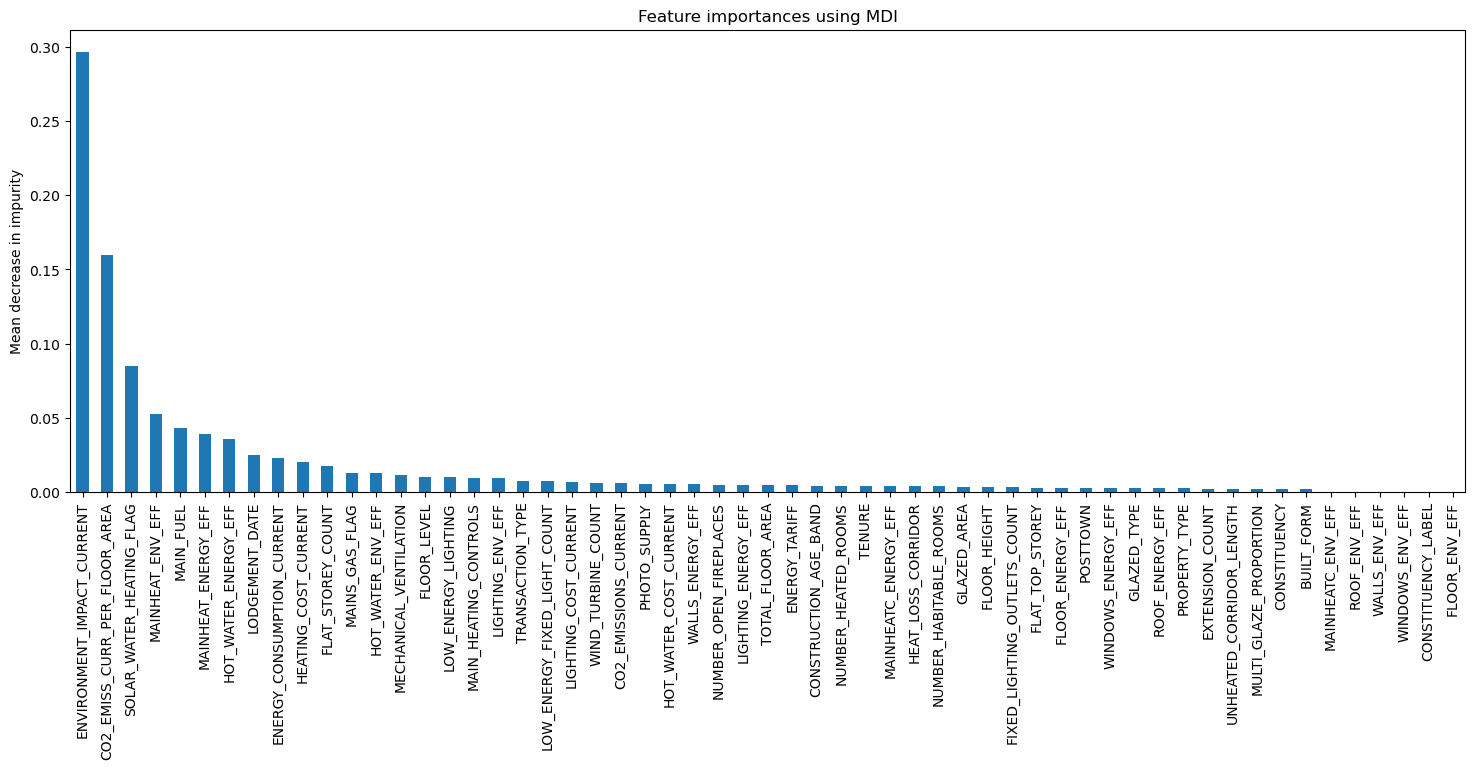

In [18]:
importances = xgb_clf.feature_importances_
# std = np.std([tree.feature_importances_ for tree in clf.estimators_], axis=0)
forest_importances = pd.Series(importances, index=X_train.columns).sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(18,6))
forest_importances.plot.bar(ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity");
# fig.tight_layout()


This shows the overall contribution of each feature to the classification. "ENVIRONMENT_IMPACT_CURRENT" is the highest, but it might not be available in practice. It would be worthwile to retrain without it and see how it impacts the performance.

Now let's try Shapley additive explanations per class.

In [19]:
explainer = shap.TreeExplainer(xgb_clf)
shap_values = explainer.shap_values(X_test)

[10:33:49] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1705650052425/work/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


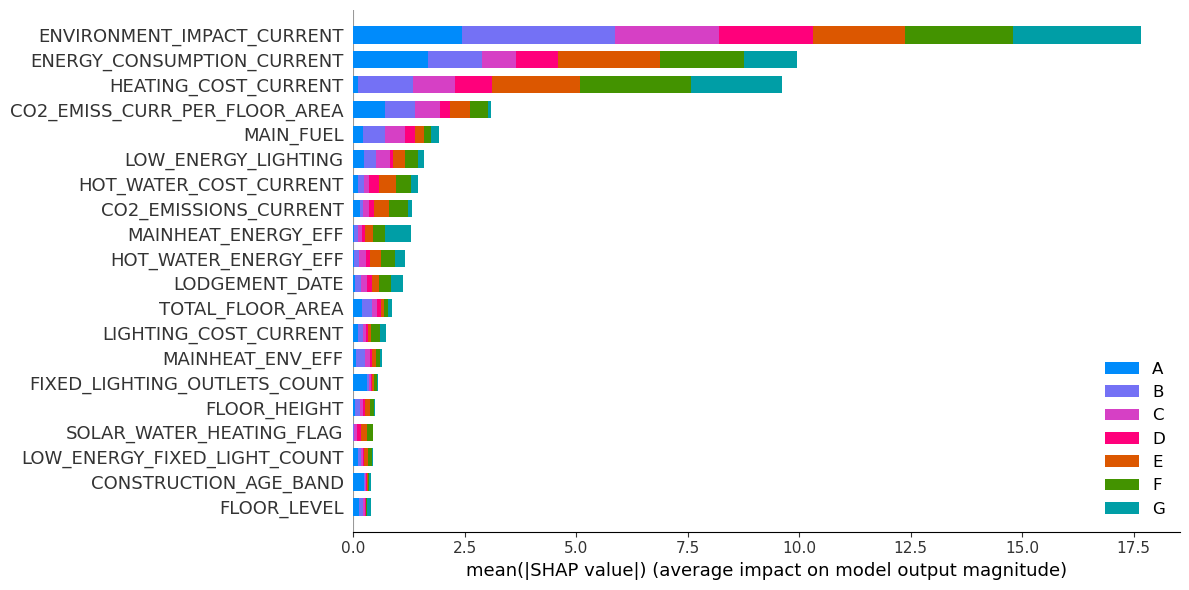

In [20]:
shap.summary_plot(
    shap_values=shap_values,
    features=X_test,
    feature_names=X_test.columns.tolist(),
    plot_type='bar',
    class_names=data[feature_to_predict].cat.categories,
    class_inds='original',
    plot_size=(12,6)
)

Once again "ENVIRONMENT_IMPACT_CURRENT is the highest, but now "HEATING_COST_CURRENT" and "ENERGY_CONSUMPTION_CURRENT" appear relatively more important (they were already relatively important with MDI).

What's interesting here is the per-class breakdown.
- "HEATING_COST_CURRENT" is more informative about lower EPC scores, as is  "MAINHEAT_ENERGY_EFF" and "CO2_EMISSIONS_CURRENT".
- Meanwhile, "CO2_EMISS_CURR_PER_FLOOR_AREA" is more informative about higher EPC scores, as is "FIXED_LIGHTING_OUTLETS_COUNT" and "TRANSACTION_TYPE".

## Future work

### Feature engineering

- Given the above analysis, some features "*_ENV_EFF" appear to be safe to remove, which would improve performance.
- More importantly, it is important to evaluate which significant features may actually not be available in practice, and how their removal affects performance. If they are key to the prediction, a regressor could be trained to predict them.
- Features that are key for underrepresented classes could be emphasized with weights.
- Some categorical features could be crossed to model non-linear relationships.
- As mentioned above, some of the features that were initially removed due to complexity could be embedded (e.g. using a language model for text or geocoding for location).

### Comparing with other models

There are plenty of other models that could be compared to LightGBM, such as those in the [InterpretML](https://github.com/interpretml/interpret/) library. Generally speaking interpretability is key here in order to evaluate how much effort needs to be invested in collecting (or approximating) specific features.

If these models have key hyperparameters, they would need tuning using hyperparameter grid search and/or optimisation.

Besides the performance metrics (including precision/recall/F1 but also train/inference time), the scaling of these models should be evaluated by plotting performance curves.

### NB: Handling missing values

While XGBoost already handles missing values, other models may not. Here's an outline of the strategy for this:
- If most values are missing (say >95%), we can probably remove the feature. After analysis, no such feature exists in the data.
- Conversely, if very few values are missing (say <5%), they can probably be safely imputed from the data.
- For ratios in between, the missing value is encoded as a special value. The fact that the value is missing could be informative.

In [21]:
# imputed_features = []
# for feature in train_set.columns:
#     ratio = train_set[feature].isna().sum() / len(train_set.index)
#     if ratio > 0 and ratio < 0.05:
#         print(f"{feature}:", ratio, train_set[feature].dtype)
#     imputed_features.append(feature)